In [14]:
# https://github.com/yingkaisha/keras-vision-transformer/blob/main/examples/Swin_UNET_oxford_iiit.ipynb
import numpy as np
from glob import glob
import tensorflow as tf
# from tensorflow import keras

# ADICIONAR MODELO: fiz get_config em todas as classes..

In [15]:
#!git clone https://github.com/yingkaisha/keras-vision-transformer.git

import sys
sys.path.append('../')

from keras_vision_transformer import transformer_layers, swin_layers
from keras_vision_transformer import util_layers,utils

## 🏿 GPU and CUDA

In [16]:
from psutil import virtual_memory       
gpu = !nvidia-smi --query-gpu=gpu_name --format=csv,noheader
ram_gb = virtual_memory().total / 1e9
print(f'{gpu.s} with {round(ram_gb,1)} GB of available RAM.\n')
!nvcc --version

NVIDIA GeForce RTX 3090 with 34.2 GB of available RAM.

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_22:08:44_Pacific_Standard_Time_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [5]:
# the indicator of a fresh run
first_time_running = False

## ⚙ Configurations

In [61]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense, Conv2D, concatenate
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy  # binary cross-entropy          
from tensorflow.keras.metrics import Precision 
from tensorflow.keras.metrics import Recall
from segmentation_models.metrics import IOUScore        # Jaccard index

CONFIGS = dict(
    BATCH_SZ = 4,
    IMG_SIZE = (256, 256),   
    SEED = 42,               
    CLASS_NUM = 1,
    REF_FILTERS = 128,      # reference number for U-NET filters
    F_INIT = "he_normal",   # Kaiming He initialization    
    EPOCHS = 100,           # training epochs
    OPTIMIZER = Adam(learning_rate=1e-4, clipvalue=0.5), 
    LOSS = BinaryCrossentropy(label_smoothing=0.1),              
    CONV_ACTIV = Activation(tf.nn.relu),    
    DTYPE = np.float32,                      
    METRICS = [Precision(thresholds=0.5), 
               Recall(thresholds=0.5)],
)

FILTER_NUM_BEGIN = 256      # number of channels in the first downsampling block; it is also the number of embedded dimensions
DEPTH = 4                   # the depth of SwinUNET; depth=4 means three down/upsampling levels and a bottom level
STACK_NUM_DOWN = 3          # number of Swin Transformers per downsampling level 
STACK_NUM_UP = 3            # number of Swin Transformers per upsampling level
PATCH_SIZE = (4, 4)         # Extract 4-by-4 patches from the input image. Height and width of the patch must be equal.
NUM_HEADS = [4, 8, 8, 8]    # number of attention heads per down/upsampling level
WINDOW_SIZE = [4, 2, 2, 2]  # the size of attention window per down/upsampling level
NUM_MLP = 512               # number of MLP nodes within the Transformer
SHIFT_WINDOW=True           # Apply window shifting, i.e., Swin-MSA

In [40]:
# import os
# DIR = os.getcwd()
# ANN_FILE = os.path.join(DIR, 'data\\result.json')
# MSKS_DIR = os.path.join(DIR, 'data\\masks')
# IMGS_DIR = os.path.join(DIR, 'data\\images')
# NO_LABEL_DIR = os.path.join(DIR, 'output_MSRCR_total\\1')
# os.makedirs(DIR + '\\checkpoints\\SwinUNET', exist_ok = True)
# CHCKPNT_MODELS = os.path.join(DIR, 'checkpoints\\SwinUNET')
# BATCH_SIZE = 4
# #IMG_SIZE = (256,256)
# IMG_SIZE = (512,512)
# SEED = 42


# Hyperparameters of the Swin-UNET are listed as follows:

# # V1
# filter_num_begin = 128      # number of channels in the first downsampling block; it is also the number of embedded dimensions
# depth = 4                   # the depth of SwinUNET; depth=4 means three down/upsampling levels and a bottom level 
# stack_num_down = 3          # number of Swin Transformers per downsampling level
# stack_num_up = 3            # number of Swin Transformers per upsampling level
# patch_size = (4, 4)         # Extract 4-by-4 patches from the input image. Height and width of the patch must be equal.
# num_heads = [4, 8, 8, 8]    # number of attention heads per down/upsampling level
# window_size = [4, 2, 2, 2]  # the size of attention window per down/upsampling level
# num_mlp = 512               # number of MLP nodes within the Transformer
# shift_window=True           # Apply window shifting, i.e., Swin-MSA

# V2
# FILTER_NUM_BEGIN = 128      # number of channels in the first downsampling block; it is also the number of embedded dimensions
# DEPTH = 4                   # the depth of SwinUNET; depth=4 means three down/upsampling levels and a bottom level
# STACK_NUM_DOWN = 3          # number of Swin Transformers per downsampling level 
# STACK_NUM_UP = 3            # number of Swin Transformers per upsampling level
# PATCH_SIZE = (4, 4)         # Extract 4-by-4 patches from the input image. Height and width of the patch must be equal.
# NUM_HEADS = [4, 8, 8, 8]    # number of attention heads per down/upsampling level
# WINDOW_SIZE = [4, 2, 2, 2]  # the size of attention window per down/upsampling level
# NUM_MLP = 512              # number of MLP nodes within the Transformer
# SHIFT_WINDOW=True           # Apply window shifting, i.e., Swin-MSA

### 📁 Data source paths and directory creation

In [62]:
import os
from glob import glob
DIR = os.getcwd()
ANN_FILE = os.path.join(DIR, 'data_800_600\\result.json')
IMGS_DIR = os.path.join(DIR, 'data_800_600\\images')
MSKS_DIR = os.path.join(DIR, 'data_800_600\\masks')
NO_LABEL_DIR = os.path.join(DIR, 'output_Waternet')
imgs_no_lbl_paths = sorted(glob(NO_LABEL_DIR + '\\C5\\**\\*.png', recursive=True) +
                           glob(NO_LABEL_DIR + '\\C6\\**\\*.png', recursive=True)) 
CHCKPNT_MODELS = os.path.join(DIR, 'checkpoints\\swin_net')
LOGS = os.path.join(DIR, 'logs\\unet_v2')
os.makedirs(LOGS, exist_ok=True)

## SwinUNET Model

![](swin_unet.png "Swin U-Net Diagram")

In [63]:
def swin_transformer_stack(X, stack_num, embed_dim, num_patch, num_heads, window_size, num_mlp, shift_window=True, name=''):
    '''
    Stacked Swin Transformers that share the same token size.
    
    Alternated Window-MSA and Swin-MSA will be configured if `shift_window=True`, Window-MSA only otherwise.
    *Dropout is turned off.
    '''
    # Turn-off dropouts
    mlp_drop_rate = 0 # Droupout after each MLP layer
    attn_drop_rate = 0 # Dropout after Swin-Attention
    proj_drop_rate = 0 # Dropout at the end of each Swin-Attention block, i.e., after linear projections
    drop_path_rate = 0 # Drop-path within skip-connections
    
    qkv_bias = True # Convert embedded patches to query, key, and values with a learnable additive value
    qk_scale = None # None: Re-scale query based on embed dimensions per attention head # Float for user specified scaling factor
    
    if shift_window:
        shift_size = window_size // 2
    else:
        shift_size = 0
    
    for i in range(stack_num):
    
        if i % 2 == 0:
            shift_size_temp = 0
        else:
            shift_size_temp = shift_size

        X = swin_layers.SwinTransformerBlock(dim=embed_dim, 
                                             num_patch=num_patch, 
                                             num_heads=num_heads, 
                                             window_size=window_size, 
                                             shift_size=shift_size_temp, 
                                             num_mlp=num_mlp, 
                                             qkv_bias=qkv_bias, 
                                             qk_scale=qk_scale,
                                             mlp_drop=mlp_drop_rate, 
                                             attn_drop=attn_drop_rate, 
                                             proj_drop=proj_drop_rate, 
                                             drop_path_prob=drop_path_rate, 
                                             name='name{}'.format(i))(X)
    return X


def swin_unet_2d_base(input_tensor, filter_num_begin, depth, stack_num_down, stack_num_up, 
                      patch_size, num_heads, window_size, num_mlp, shift_window=True, name='swin_unet'):
    '''
    The base of Swin-UNET.
    
    The general structure:
    
    1. Input image --> a sequence of patches --> tokenize these patches
    2. Downsampling: swin-transformer --> patch merging (pooling)
    3. Upsampling: concatenate --> swin-transfprmer --> patch expanding (unpooling)
    4. Model head
    
    '''
    # Compute number be patches to be embeded
    input_size = input_tensor.shape.as_list()[1:]
    num_patch_x = input_size[0]//patch_size[0]
    num_patch_y = input_size[1]//patch_size[1]
    
    # Number of Embedded dimensions
    embed_dim = filter_num_begin
    
    depth_ = depth
    
    X_skip = []

    X = input_tensor
    
    # Patch extraction
    X = transformer_layers.patch_extract(patch_size)(X)

    # Embed patches to tokens
    X = transformer_layers.patch_embedding(num_patch_x*num_patch_y, embed_dim)(X)
    
    # The first Swin Transformer stack
    X = swin_transformer_stack(X, 
                               stack_num=stack_num_down, 
                               embed_dim=embed_dim, 
                               num_patch=(num_patch_x, num_patch_y), 
                               num_heads=num_heads[0], 
                               window_size=window_size[0], 
                               num_mlp=num_mlp, 
                               shift_window=shift_window, 
                               name='{}_swin_down0'.format(name))
    X_skip.append(X)
    
    # Downsampling blocks
    for i in range(depth_-1):
        
        # Patch merging
        X = transformer_layers.patch_merging((num_patch_x, num_patch_y), embed_dim=embed_dim, name='down{}'.format(i))(X)
        
        # update token shape info
        embed_dim = embed_dim*2
        num_patch_x = num_patch_x//2
        num_patch_y = num_patch_y//2
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, 
                                   stack_num=stack_num_down, 
                                   embed_dim=embed_dim, 
                                   num_patch=(num_patch_x, num_patch_y), 
                                   num_heads=num_heads[i+1], 
                                   window_size=window_size[i+1], 
                                   num_mlp=num_mlp, 
                                   shift_window=shift_window, 
                                   name='{}_swin_down{}'.format(name, i+1))
        
        # Store tensors for concat
        X_skip.append(X)
        
    # reverse indexing encoded tensors and hyperparams
    X_skip = X_skip[::-1]
    num_heads = num_heads[::-1]
    window_size = window_size[::-1]
    
    # upsampling begins at the deepest available tensor
    X = X_skip[0]
    
    # other tensors are preserved for concatenation
    X_decode = X_skip[1:]
    
    depth_decode = len(X_decode)
    
    for i in range(depth_decode):
        
        # Patch expanding
        X = transformer_layers.patch_expanding(num_patch=(num_patch_x, num_patch_y), 
                                               embed_dim=embed_dim, 
                                               upsample_rate=2, 
                                               return_vector=True)(X)
        
        # update token shape info
        embed_dim = embed_dim//2
        num_patch_x = num_patch_x*2
        num_patch_y = num_patch_y*2
        
        # Concatenation and linear projection
        X = concatenate([X, X_decode[i]], axis=-1, name='{}_concat_{}'.format(name, i))
        X = Dense(embed_dim, use_bias=False, name='{}_concat_linear_proj_{}'.format(name, i))(X)
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, 
                                   stack_num=stack_num_up, 
                                   embed_dim=embed_dim, 
                                   num_patch=(num_patch_x, num_patch_y), 
                                   num_heads=num_heads[i], 
                                   window_size=window_size[i], 
                                   num_mlp=num_mlp, 
                                   shift_window=shift_window, 
                                   name='{}_swin_up{}'.format(name, i))
        
    # The last expanding layer; it produces full-size feature maps based on the patch size
    # !!! <--- "patch_size[0]" is used; it assumes patch_size = (size, size)
    
    X = transformer_layers.patch_expanding(num_patch=(num_patch_x, num_patch_y), 
                                           embed_dim=embed_dim, 
                                           upsample_rate=patch_size[0], 
                                           return_vector=False)(X)
    
    return X

In [64]:

IN = Input(CONFIGS['IMG_SIZE'] + (3,))

# Base architecture
X = swin_unet_2d_base(IN, FILTER_NUM_BEGIN, DEPTH, STACK_NUM_DOWN, STACK_NUM_UP, 
                      PATCH_SIZE, NUM_HEADS, WINDOW_SIZE, NUM_MLP, 
                      shift_window=SHIFT_WINDOW, name='swin_unet')
# Output section
n_labels = 1
OUT = Conv2D(n_labels, kernel_size=1, use_bias=False, activation='sigmoid')(X)

# Model configuration
model = Model(inputs=[IN,], outputs=[OUT,])

In [52]:
# Optimization
#from tensorflow.keras.metrics import Precision         
#from tensorflow.keras.metrics import Recall 
#opt = tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=0.5) # <---- !!! gradient clipping is important
#model.compile(loss=tf.keras.losses.binary_crossentropy, 
#              optimizer=opt,
#              metrics= ['accuracy'])

### Model instantiation and compilation

In [65]:
from tensorflow.keras.optimizers.experimental import AdamW

model.compile(optimizer = CONFIGS['OPTIMIZER'], 
              loss = CONFIGS['LOSS'],
              metrics = [CONFIGS['METRICS']]
             )

# Data Augmentation

### Data Augmentation configurations

In [66]:
ROT_RANGE = 30
SHEAR_RANGE = 0.2
FILL_MODE = 'nearest'
HORIZ_FLIP = True
ZOOM_RANGE = [0.7, 1]
BRIGHT_RANGE = [0.8, 1.2]

## Images Data Augmentation

In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_gen = ImageDataGenerator(rotation_range = ROT_RANGE,
                             shear_range = SHEAR_RANGE,
                             fill_mode=FILL_MODE,       
                             horizontal_flip = HORIZ_FLIP, 
                             zoom_range = ZOOM_RANGE,
                             brightness_range = BRIGHT_RANGE,
                             validation_split = 0.15,
                             rescale=1./255)
img_gen_valid = ImageDataGenerator(validation_split = 0.15,
                                   rescale=1./255)

img_trn_dset = img_gen.flow_from_directory(directory = IMGS_DIR,
                                           batch_size = CONFIGS['BATCH_SZ'],
                                           target_size = CONFIGS['IMG_SIZE'],
                                           color_mode="rgb",
                                           class_mode=None,
                                           subset="training",
                                           seed = CONFIGS['SEED'])

img_vld_dset = img_gen_valid.flow_from_directory(directory = IMGS_DIR,
                                                 batch_size = CONFIGS['BATCH_SZ'],
                                                 target_size = CONFIGS['IMG_SIZE'],
                                                 color_mode="rgb",
                                                 class_mode=None,
                                                 subset="validation",
                                                 seed = CONFIGS['SEED'])

Found 68 images belonging to 1 classes.
Found 11 images belonging to 1 classes.


## Masks Data Augmentation

In [68]:
msk_gen = ImageDataGenerator(rotation_range = ROT_RANGE,
                             shear_range = SHEAR_RANGE,
                             fill_mode=FILL_MODE,        
                             horizontal_flip = HORIZ_FLIP, 
                             zoom_range = ZOOM_RANGE,
                             validation_split = 0.15,
                             rescale=1./255)

msk_gen_valid = ImageDataGenerator(validation_split = 0.15,
                                   rescale=1./255)

msk_trn_dset = msk_gen.flow_from_directory(directory = MSKS_DIR,
                                           batch_size = CONFIGS['BATCH_SZ'],
                                           target_size = CONFIGS['IMG_SIZE'],
                                           color_mode="grayscale",
                                           class_mode=None,
                                           subset="training",
                                           seed = CONFIGS['SEED'])

msk_vld_dset = msk_gen_valid.flow_from_directory(directory = MSKS_DIR,
                                                 batch_size = CONFIGS['BATCH_SZ'],
                                                 target_size = CONFIGS['IMG_SIZE'],
                                                 color_mode="grayscale",
                                                 class_mode=None,
                                                 subset="validation",
                                                 seed = CONFIGS['SEED'])

Found 68 images belonging to 1 classes.
Found 11 images belonging to 1 classes.


#### Data Augmentation Visualization (*Sanity Check*)

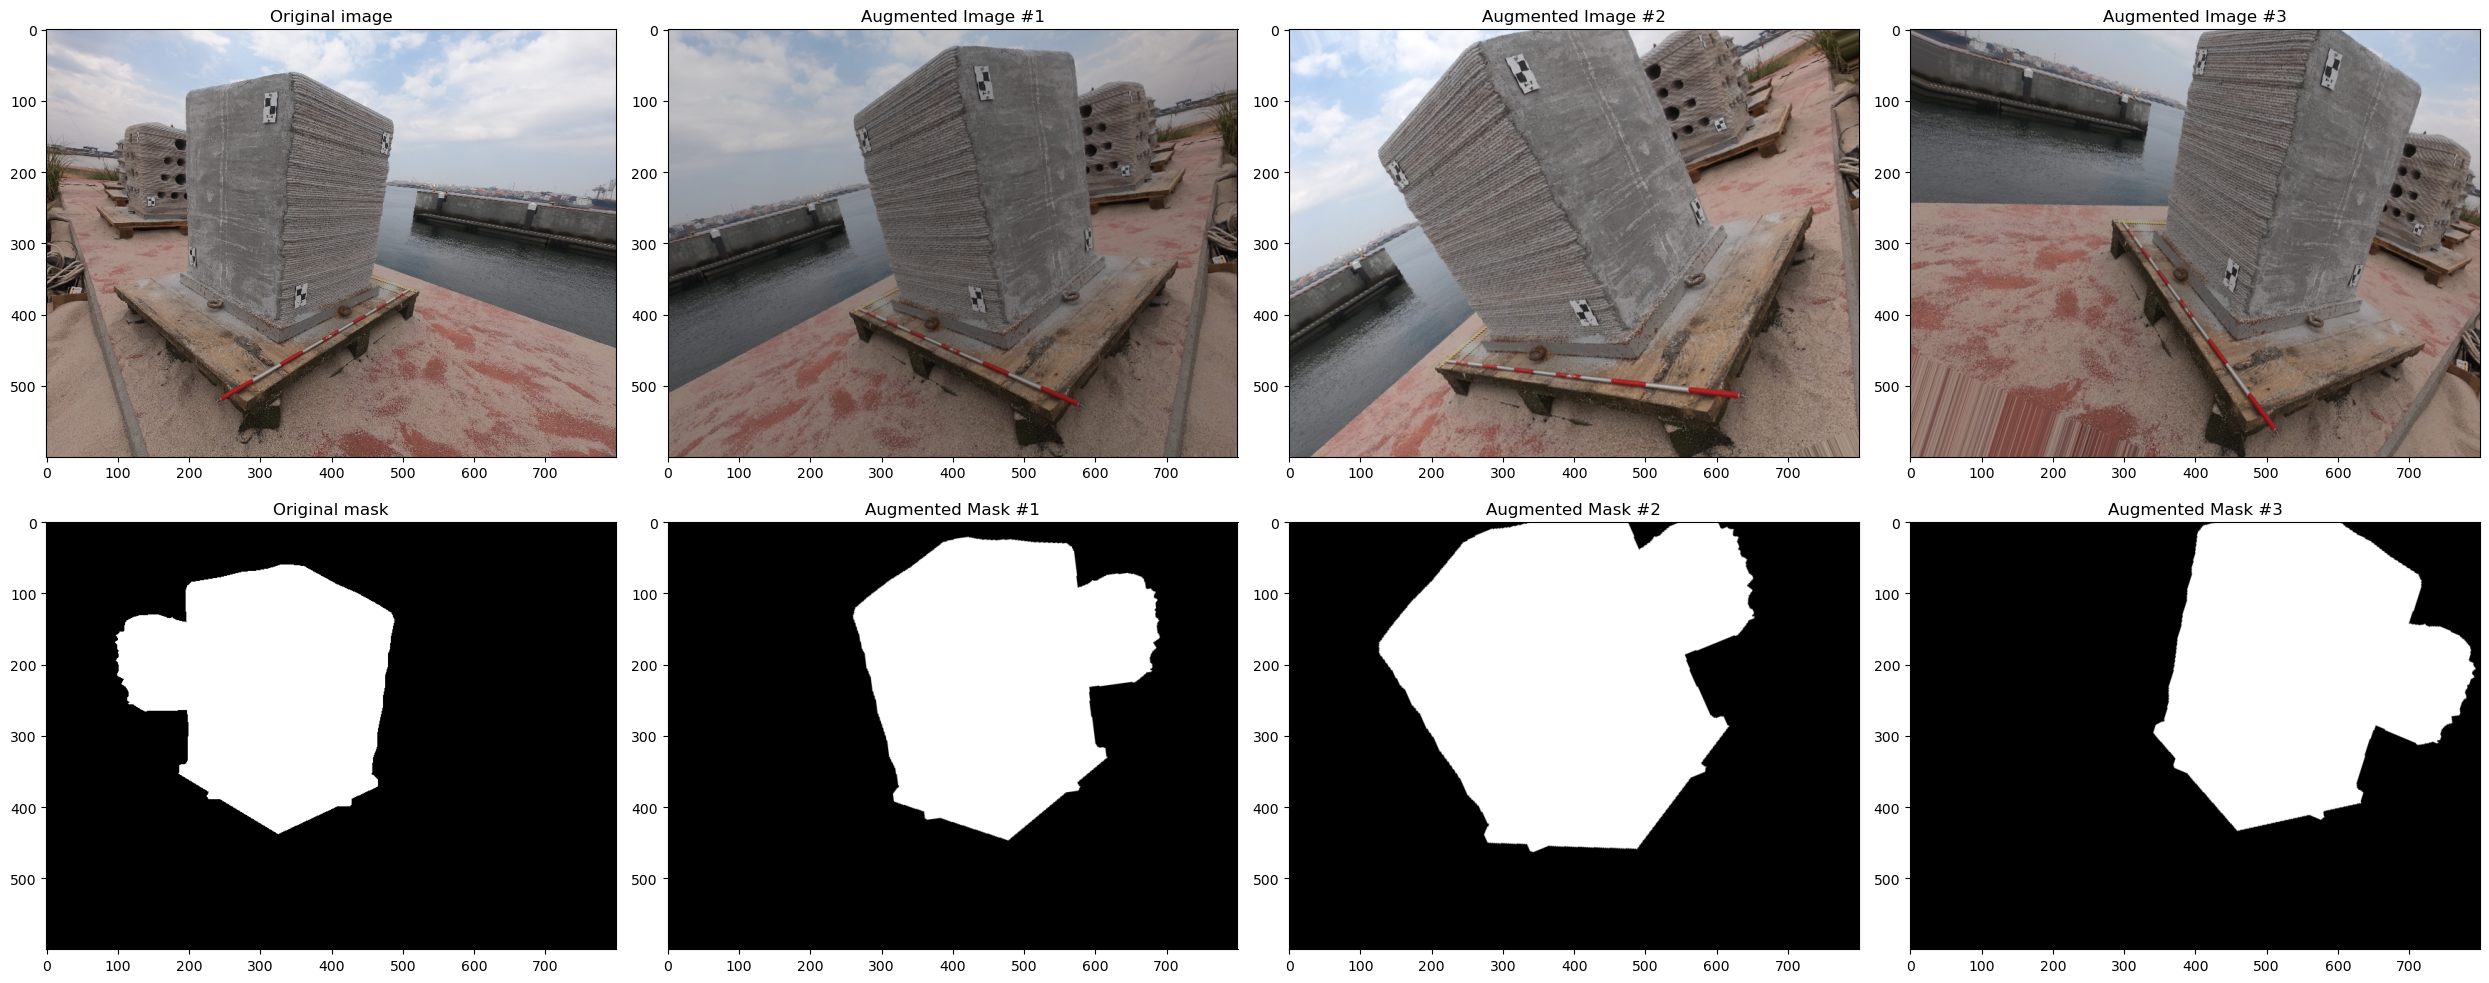

In [70]:
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as plt
from glob import glob
import random

img_paths = sorted(glob(IMGS_DIR + '\\0\\*.PNG')) 
idx = random.choice(range(0, len(img_paths)-1))

img = load_img(img_paths[idx])
img_exp = np.expand_dims(img, axis=0)
img_iter = img_gen.flow(img_exp, batch_size=1, seed = CONFIGS['SEED'])

msks_paths = sorted(glob(MSKS_DIR + '\\0\\*.PNG')) 
msk = load_img(msks_paths[idx])
msk_exp = np.expand_dims(msk, axis=0)
msk_iter = msk_gen.flow(msk_exp, batch_size=1, seed = CONFIGS['SEED'])

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(25,10))

ax[0,0].imshow(img)
ax[0,0].set_title("Original image")

ax[1,0].imshow(msk)
ax[1,0].set_title("Original mask")

for i in range(3):
    image = next(img_iter)[0]
    ax[0, i+1].set_title(f"Augmented Image #{i+1}")
    ax[0, i+1].imshow(image)

    mask = next(msk_iter)[0]
    ax[1, i+1].set_title(f"Augmented Mask #{i+1}")
    ax[1, i+1].imshow(mask)

plt.tight_layout();

#### Train and Validation Generators

In [71]:
train_generator = zip(img_trn_dset, msk_trn_dset)
valid_generator = zip(img_vld_dset, msk_vld_dset)

#### metrics_graphs

In [72]:
def metrics_graphs(history, model, model_conf="not provided!", metrics=['loss'], y_log=False):
    """
    Plots training and validation metrics of a Keras model during training.
    Parameters:
    -----------
    history: tf.keras.callbacks.History
        Object returned by model.fit() containing training history.
    model: tf.keras.Model
        The trained machine learning model.
    conf_modelo: str, optional (default="")
        The configuration of the model (optional)
    metrics: list of str, optional (default=['loss'])
        The metrics to plot. Must be keys in the history object.
    y_log: bool, optional(default=False) 
        Whether to use logarithmic scale for the y-axis on the loss plot. 
        Defaults to False.
    """

    if not isinstance(history, tf.keras.callbacks.History):
        raise TypeError("The 'history' argument must be a tf.keras.callbacks. History object.")
    if not isinstance(model, tf.keras.Model):
        raise TypeError("The 'model' argument must be a tf.keras.Model object.")
    if not isinstance(model_conf, str):
        raise TypeError("The 'model_conf' argument must be a string.")
        
    plt.style.use('fast') 

    n_metrics = len(metrics)
    fig, axs = plt.subplots(1, n_metrics, figsize=(25, 8))

    if n_metrics == 1:
        axs = [axs]

    for i, metric in enumerate(metrics):
        if metric not in history.history or f"val_{metric}" not in history.history:
            raise ValueError(f"{metric} not found in the history object.")

        axs[i].plot(history.history[metric], "limegreen", marker=".", alpha=0.7)
        axs[i].plot(history.history[f"val_{metric}"], "orangered", marker=".", alpha=0.7)
        axs[i].set_title(f"{metric.title()} of {model.name}\nConfiguration: {model_conf}")
        axs[i].set_ylabel(metric.title())
        axs[i].set_xlabel('Epoch')
        axs[i].legend(['train', 'validation'], loc='best')
        axs[i].grid(linestyle='--', linewidth=0.4)

        xmax = np.argmax(history.history[f"val_{metric}"])
        ymax = max(history.history[f"val_{metric}"])
        text = f"{metric.title()} Val.: {ymax:.3f}"
        bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.5)
        arrowprops1 = dict(arrowstyle="->", connectionstyle="arc3,rad=0.3")
        kw = dict(xycoords='data', textcoords="offset points",
                  arrowprops=arrowprops1, bbox=bbox_props, ha="right", va="center")
        axs[i].annotate(text, xy=(xmax, ymax), xytext=(-15, -30), **kw)

        if metric == 'loss' and y_log:
            axs[i].set_yscale('log')

    plt.tight_layout()

##### create_run_string

In [73]:
from datetime import datetime
def create_run_string(img_size, model_name = "NN",fold=None, use_cross_val=False):
    """Create a string for each training run.

    Args:
        img_size (tuple): The size (height, width) of the images.
        model_name: (str,optional): the designation of the model. Defaults to "NN".
        fold (int, optional): The fold number for cross-validation. Defaults to None.
        use_cross_val (bool, optional): Whether or not to use cross-validation. Defaults to False.

    Returns:
        str: The string for the training run.
    """
    now = datetime.now()
    dt_string = now.strftime("%d_%b_%Hh%Mmin")
    str_run = f"{model_name}_{img_size[0]}x{img_size[1]}_DT_{dt_string}"
    if use_cross_val:
        str_run += f"_fold_{fold}"
    return str_run

##### callback_funcs

In [75]:
def callback_funcs(str_run, monitor_metric='val_loss', mode='min', reduce_factor=0.5,
                   reduce_patience=10, fold_n=0, additional_callbacks=[], callback_list=[]):
    """
    Creates a list of Keras callbacks to be used during model training.

    Parameters
    ----------
    str_run : str
        Prefix for the filenames of the CSVLogger and ModelCheckpoint callbacks.
    monitor_metric : str, optional
        Name of the metric to monitor for the ReduceLROnPlateau and ModelCheckpoint callbacks. 
        Default is 'loss'.
    mode : str, optional
        One of {'min', 'max', 'auto'}. 
        Specifies whether the monitored metric should be minimized, maximized, or inferred automatically for the ModelCheckpoint callback. 
        Default is 'min'.
    reduce_factor : float, optional
        Factor by which to reduce the learning rate when there is no improvement in monitored metric after reduce_patience epochs.
        Default is 0.5.
    reduce_patience : int, optional
        Number of epochs with no improvement after which to reduce the learning rate for the ReduceLROnPlateau callback.
        Default is 10.
    additional_callbacks : list, optional
        List of additional Keras callbacks to be added to the output list.
        Default is [].
    callback_list : list, optional
        List of callback names to activate. 
        Available options are 'csv_logger', 'reduce_lr', and 'checkpoint'.
        Default is [] which activates all callbacks.

    Returns
    -------
    list
        A list of Keras callbacks to be used during model training.

    """   

    # Learning Schedule
    # Reduce learning rate when there is no improvement in monitored metric 
    # after a certain number of epochs
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor=monitor_metric,
        factor=reduce_factor,
        mode=mode,
        patience=reduce_patience,
        verbose=1,
        min_lr=1e-6)
    
    # Training Logs
    # Log training metrics to a CSV file
    csv_logger = tf.keras.callbacks.CSVLogger(
        os.path.join(LOGS, str_run + '.csv'),
        separator=",",
        append=True)
    
    # Model Checkpoint
    # Save the best model based on monitored metric on validation data
    checkpoint_filepath = os.path.join(CHCKPNT_MODELS, str_run +'.h5')
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        mode=mode,
        verbose=1,
        monitor=monitor_metric)
    
    callbacks = []
    
    if not callback_list:
        callbacks = [csv_logger, reduce_lr, checkpoint] + additional_callbacks
    else:
        if 'csv_logger' in callback_list:
            callbacks.append(csv_logger)
        if 'reduce_lr' in callback_list:
            callbacks.append(reduce_lr)
        if 'checkpoint' in callback_list:
            callbacks.append(checkpoint)
        callbacks += additional_callbacks
    
    return callbacks

## Learning Rate Finder

In [76]:
%%time
from lr_find import LrFinder
from one_cycle import OneCycleLr

# Instantiate LrFinder
lr_find = LrFinder(model, CONFIGS['OPTIMIZER'], CONFIGS['LOSS'])
# Start range_test
lr_find.range_test(train_generator, num_iter=1000)

Finding best initial lr over 1000 steps


  0%|          | 0/1000 [00:00<?, ?it/s]

LR Finder is complete, type {LrFinder}.plot_lrs() to see the graph.
CPU times: total: 2min 37s
Wall time: 3min 12s


Min numerical gradient: 8.17E-07
Min loss divided by 10: 6.67E-05


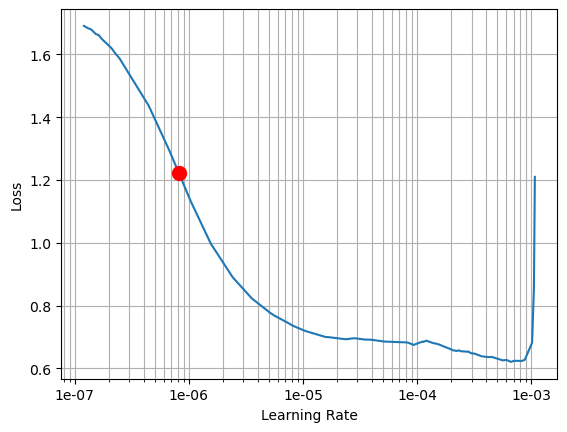

In [80]:
lr_find.plot_lrs(skip_end=0, suggestion=True, show_grid=True)

In [83]:
one_c = OneCycleLr(max_lr=lr_find.min_grad_lr, steps_per_epoch=(img_trn_dset.n // CONFIGS['BATCH_SZ'])*5, epochs=1000)

### 🏋🏽 Train the model

In [84]:
%%time
str_run = create_run_string(img_size = CONFIGS['IMG_SIZE'], model_name = "swin_net") 
history = model.fit(train_generator,
                    validation_data = valid_generator,
                    epochs = 1000,
                    batch_size = CONFIGS['BATCH_SZ'],
                    verbose = 1,
                    steps_per_epoch = (img_trn_dset.n // CONFIGS['BATCH_SZ'])*5,
                    validation_steps = img_vld_dset.n // CONFIGS['BATCH_SZ'],
                    validation_batch_size = CONFIGS['BATCH_SZ'],
                    callbacks = callback_funcs(str_run = str_run, 
                                               callback_list = ['checkpoint'], 
                                               additional_callbacks=[one_c])
                    )

Epoch 1/1000
85/85 [==============================] - ETA: 0s - loss: 1.6713 - precision_5: 0.5066 - recall_5: 0.5454
Epoch 1: val_loss improved from inf to 1.62889, saving model to c:\Users\tiago\miniconda3\envs\tf2_10\reefs\checkpoints\swin_net\swin_net_256x256_DT_17_Mar_15h38min.h5
85/85 [==============================] - 34s 246ms/step - loss: 1.6713 - precision_5: 0.5066 - recall_5: 0.5454 - val_loss: 1.6289 - val_precision_5: 0.4711 - val_recall_5: 0.5450
Epoch 2/1000
85/85 [==============================] - ETA: 0s - loss: 1.5653 - precision_5: 0.5111 - recall_5: 0.5452
Epoch 2: val_loss improved from 1.62889 to 1.54793, saving model to c:\Users\tiago\miniconda3\envs\tf2_10\reefs\checkpoints\swin_net\swin_net_256x256_DT_17_Mar_15h38min.h5
85/85 [==============================] - 18s 205ms/step - loss: 1.5653 - precision_5: 0.5111 - recall_5: 0.5452 - val_loss: 1.5479 - val_precision_5: 0.4174 - val_recall_5: 0.5439
Epoch 3/1000
85/85 [==============================] - ETA: 0s - 

### End Training

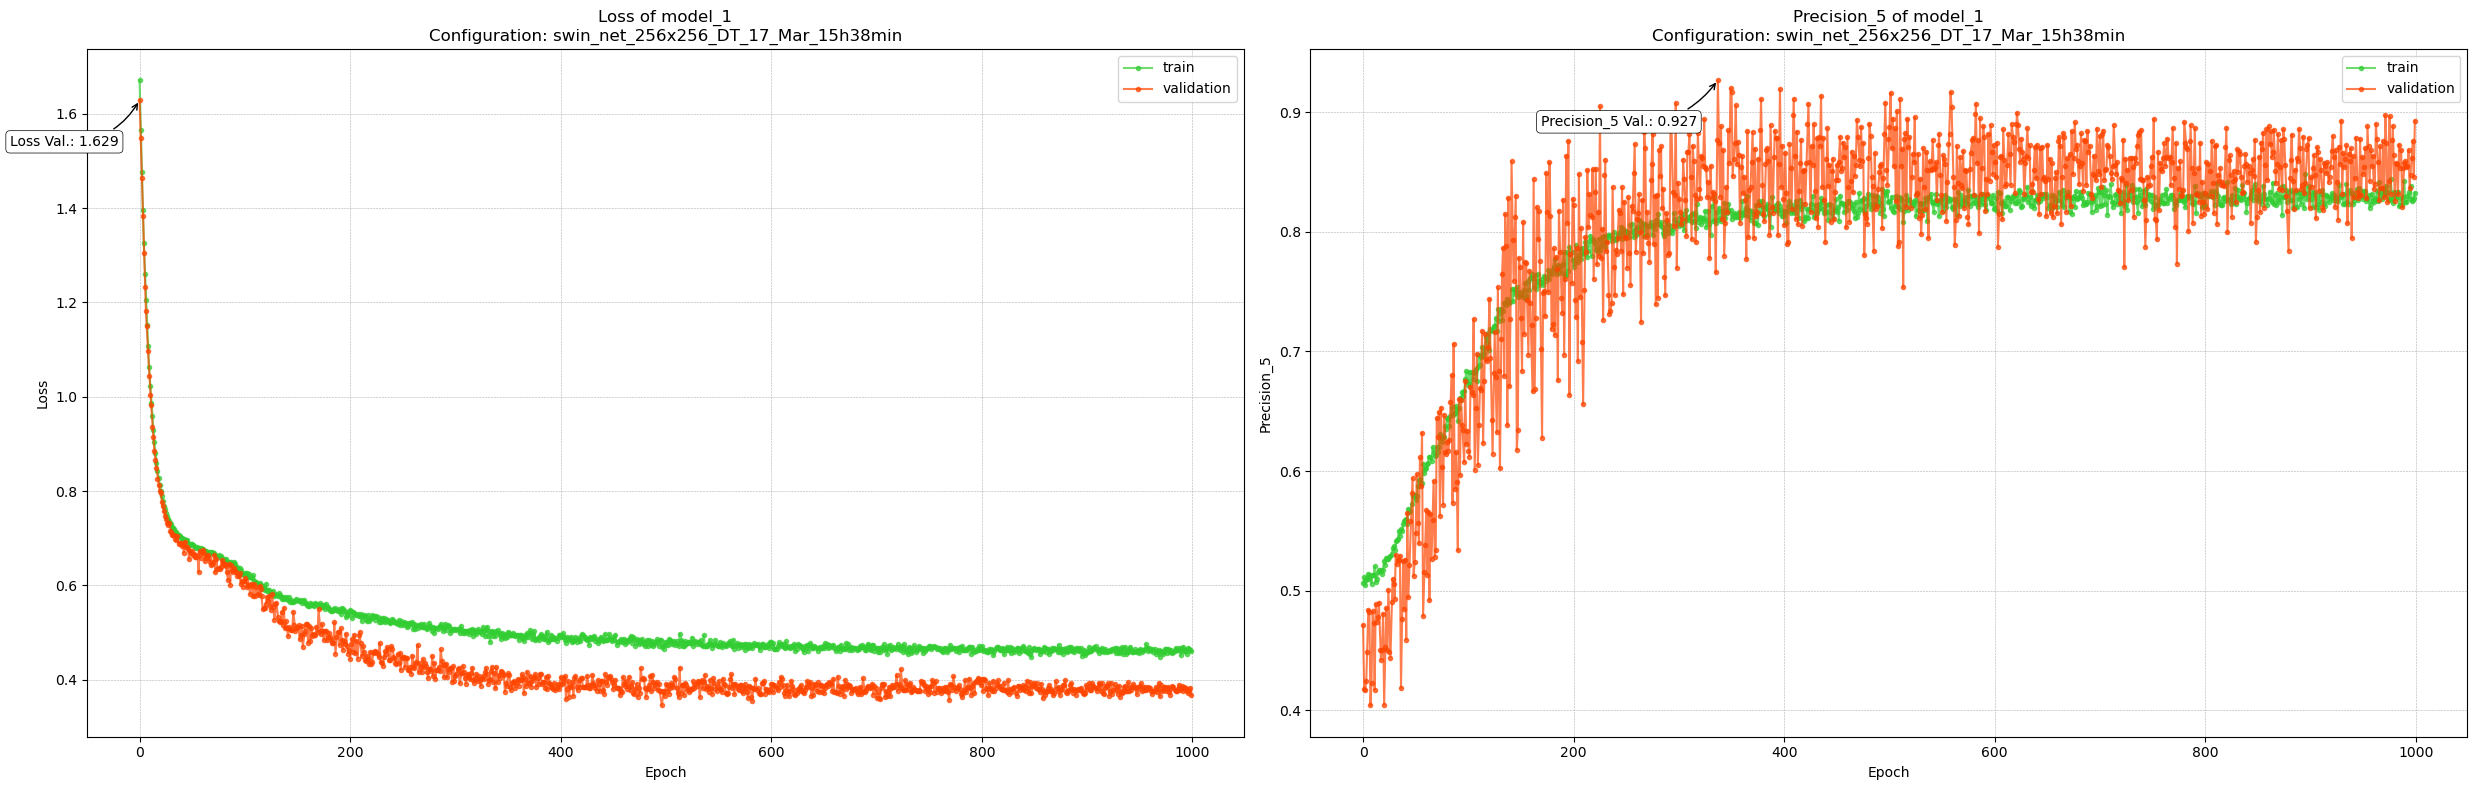

In [85]:
metrics_graphs(history, model=model, model_conf = str_run, y_log=False, metrics=['loss', 'precision_5'])

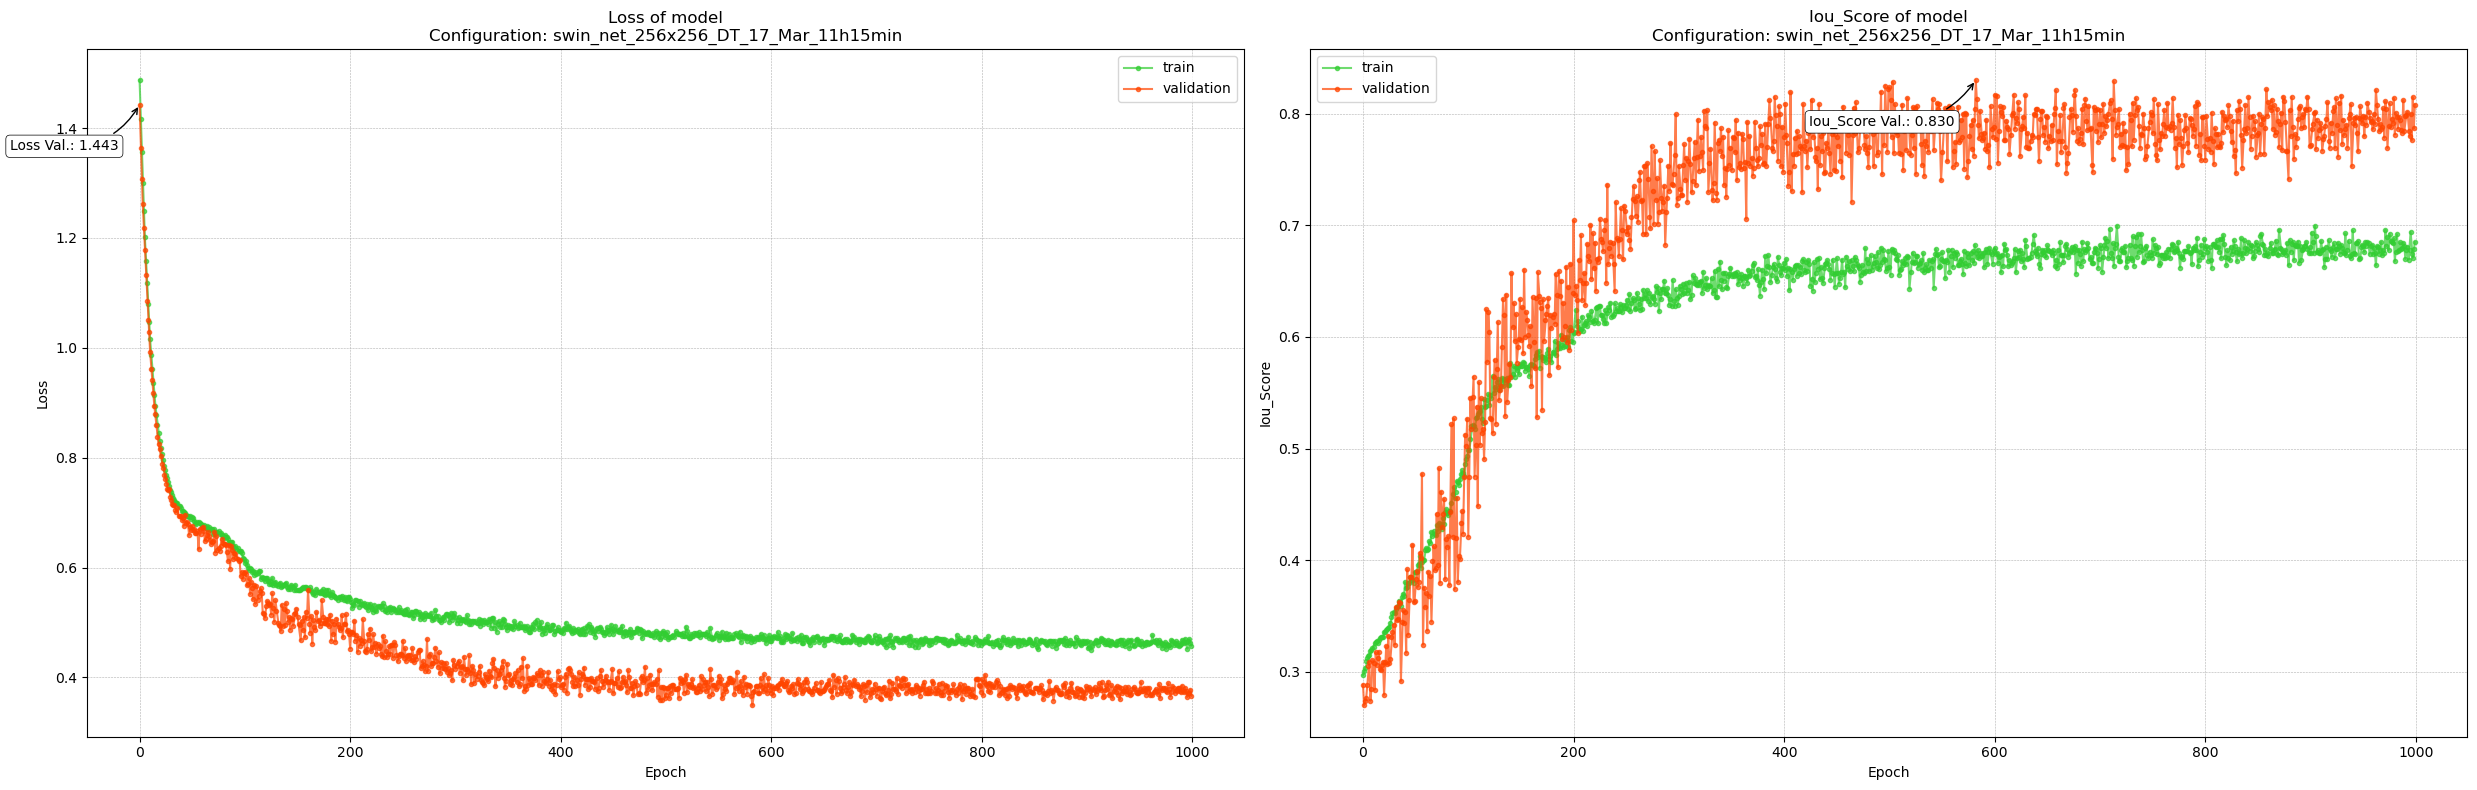

In [35]:
metrics_graphs(history, model=model, model_conf = str_run, y_log=False, metrics=['loss', 'iou_score'])

### 🔮 Inference 

In [86]:
from tensorflow.keras.layers import  Layer
model = tf.keras.models.load_model(CHCKPNT_MODELS + '\\'+str_run+'.h5')

pred_list = list()
img_list = list()
img_idx = random.sample(range(len(imgs_no_lbl_paths)), 5)
for i in range(5):
    img = tf.io.decode_jpeg(tf.io.read_file(imgs_no_lbl_paths[img_idx[i]]), channels=3)
    img = tf.image.resize(img, CONFIGS['IMG_SIZE'])
    img_list.append(img)
    img_exp = tf.expand_dims(img, axis=0)
    img_exp = tf.cast(img_exp, dtype=tf.float32) / tf.constant(256, dtype=tf.float32)
    pred = model.predict(img_exp)
    pred_list.append(pred[0] > 0.5)
    
fig, axs = plt.subplots(5, 2, figsize=(9,25), constrained_layout=True)
j = 0
for img, pred in zip(img_list, pred_list):
    axs[j, 0].imshow(np.asarray(img).astype("int"))
    axs[j, 1].imshow(np.asarray(pred).astype("int"))
    j += 1
plt.suptitle('Run Results: '+ str_run, fontsize=14);
plt.tight_layout;

ValueError: Unknown layer: patch_extract. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

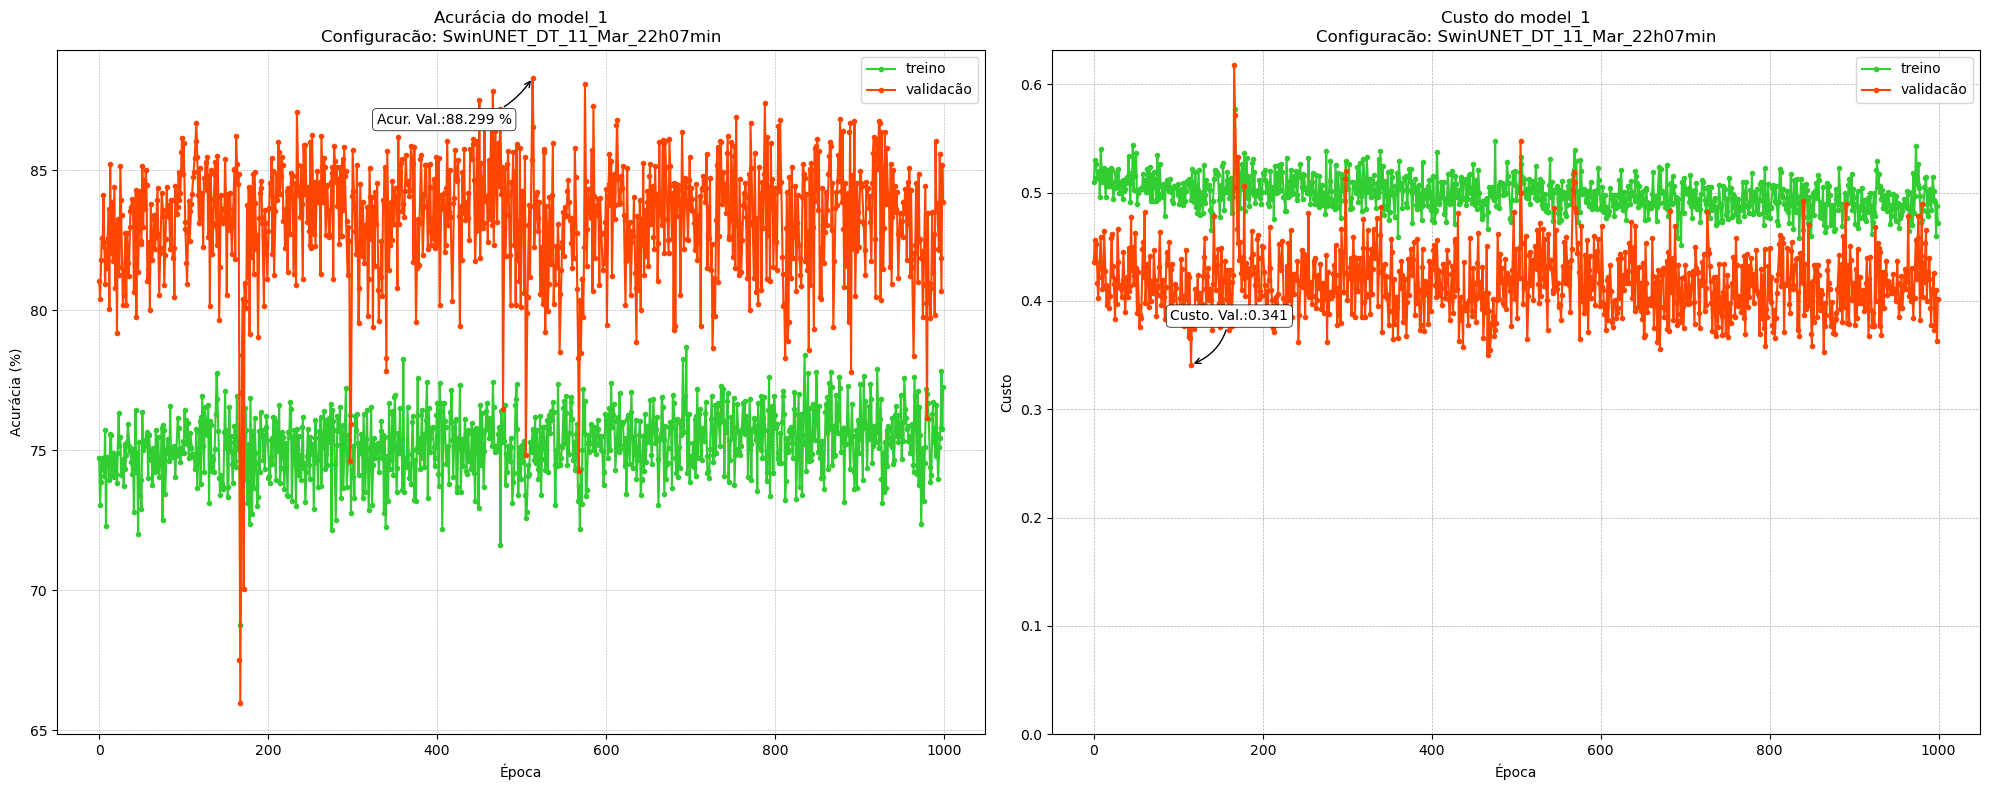

In [36]:
import matplotlib.pyplot as plt
metrics_graphs(history, model, model_conf = str_run, iou = False, y_log = True)

In [19]:
N_epoch = 100 # number of epoches
N_batch = BATCH_SIZE * 5 # number of batches per epoch
N_sample = BATCH_SIZE # number of samples per batch

tol = 0 # current early stopping patience
max_tol = 3 # the max-allowed early stopping patience
min_del = 0 # the lowest acceptable loss value reduction 

# loop over epoches
for epoch in range(N_epoch):
    
    # initial loss record
    if epoch == 0:
        y_pred = model.predict([valid_input])
        record = np.mean(keras.losses.categorical_crossentropy(valid_target, y_pred))
        print('\tInitial loss = {}'.format(record))
    
    # loop over batches
    for step in range(N_batch):
        # selecting smaples for the current batch
        ind_train_shuffle = utils.shuffle_ind(L_train)[:N_sample]
        
        # batch data formation
        ## augmentation is not applied
        train_input = input_data_process(
            utils.image_to_array(sample_names[ind_train][ind_train_shuffle], size=128, channel=3))
        train_target = target_data_process(
            utils.image_to_array(label_names[ind_train][ind_train_shuffle], size=128, channel=1))
        
        # train on batch
        loss_ = model.train_on_batch([train_input,], [train_target,])
#         if np.isnan(loss_):
#             print("Training blow-up")

        # ** training loss is not stored ** #
        
    # epoch-end validation
    y_pred = model.predict([valid_input])
    record_temp = np.mean(keras.losses.categorical_crossentropy(valid_target, y_pred))
    # ** validation loss is not stored ** #
    
    # if loss is reduced
    if record - record_temp > min_del:
        print('Validation performance is improved from {} to {}'.format(record, record_temp))
        record = record_temp; # update the loss record
        tol = 0; # refresh early stopping patience
        # ** model checkpoint is not stored ** #

    # if loss not reduced
    else:
        print('Validation performance {} is NOT improved'.format(record_temp))
        tol += 1
        if tol >= max_tol:
            print('Early stopping')
            break;
        else:
            # Pass to the next epoch
            continue;

NameError: name 'valid_input' is not defined

## Data pre-processing
The input of RGB images are resized to 128-by-128 through the nearest neighbour scheme, and then normalized to the interval of [0, 1]. The training target of pixel-wise masks are resized similarly.

A random split is applied with 80%, 10%, 10% of the samples are assigned for training, validation, and testing, respectively.

In [ ]:
def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array/255.

def target_data_process(target_array):
    '''Converting tri-mask of {1, 2, 3} to three categories.'''
    return keras.utils.to_categorical(target_array-1)